In [3]:
!pip install numpy pandas seaborn matplotlib scikit-learn imblearn shap streamlit joblib

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 44.3/44.3 kB 1.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 9.7/9.7 MB 27.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 6.9/6.9 MB 25.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 79.1/79.1 kB 5.2 MB/s eta 0:00:00


In [13]:
import pandas as pd
import numpy as np
# Load Dataset
df = pd.read_csv("/content/CP_imputedFinal.csv")
# Display first few rows
df.head()

Category        Age  Sex        ALB        ALP        ALT        AST  \
0  Hepatitis C  40.547862    1  42.171670  57.145548  19.735266  21.003655   
1      Healthy  48.052164    0  44.717738  51.708986  17.631193  21.172199   
2      Healthy  59.331927    1  39.848083  49.750461  24.419542  18.109402   
3      Healthy  40.763307    1  44.480572  75.769859  23.862050  20.981293   
4  Hepatitis C  38.153056    1  39.670539  62.251531  72.805456  43.704657   

         BIL        CHE      CHOL        CREA        GGT       PROT  
0  11.611132   7.175965  3.263660   85.489296  20.831197  76.576277  
1   2.899005   9.090976  6.865852   72.332376   7.885111  72.611708  
2  26.137381   7.430425  3.692533   83.319806  21.250551  71.413405  
3   5.063304  10.669051  4.185162   77.601685  24.472476  72.014990  
4  10.338394  10.818797  6.975503  100.128060  91.505722  73.333412

In [14]:
# Check for missing values
print("Missing values per column:\n", df.isnull().sum())

Missing values per column:
 Category    0
Age         0
Sex         0
ALB         0
ALP         0
ALT         0
AST         0
BIL         0
CHE         0
CHOL        0
CREA        0
GGT         0
PROT        0
dtype: int64


In [15]:
from sklearn.preprocessing import LabelEncoder

# Encode categorical columns
label_encoder = LabelEncoder()
df['Sex'] = label_encoder.fit_transform(df['Sex'])
df['Category'] = label_encoder.fit_transform(df['Category'])  # Target variable

In [16]:
Q1 = df.quantile(0.25)
Q3 = df.quantile(0.75)
IQR = Q3 - Q1

df = df[~((df < (Q1 - 1.5 * IQR)) | (df > (Q3 + 1.5 * IQR))).any(axis=1)]


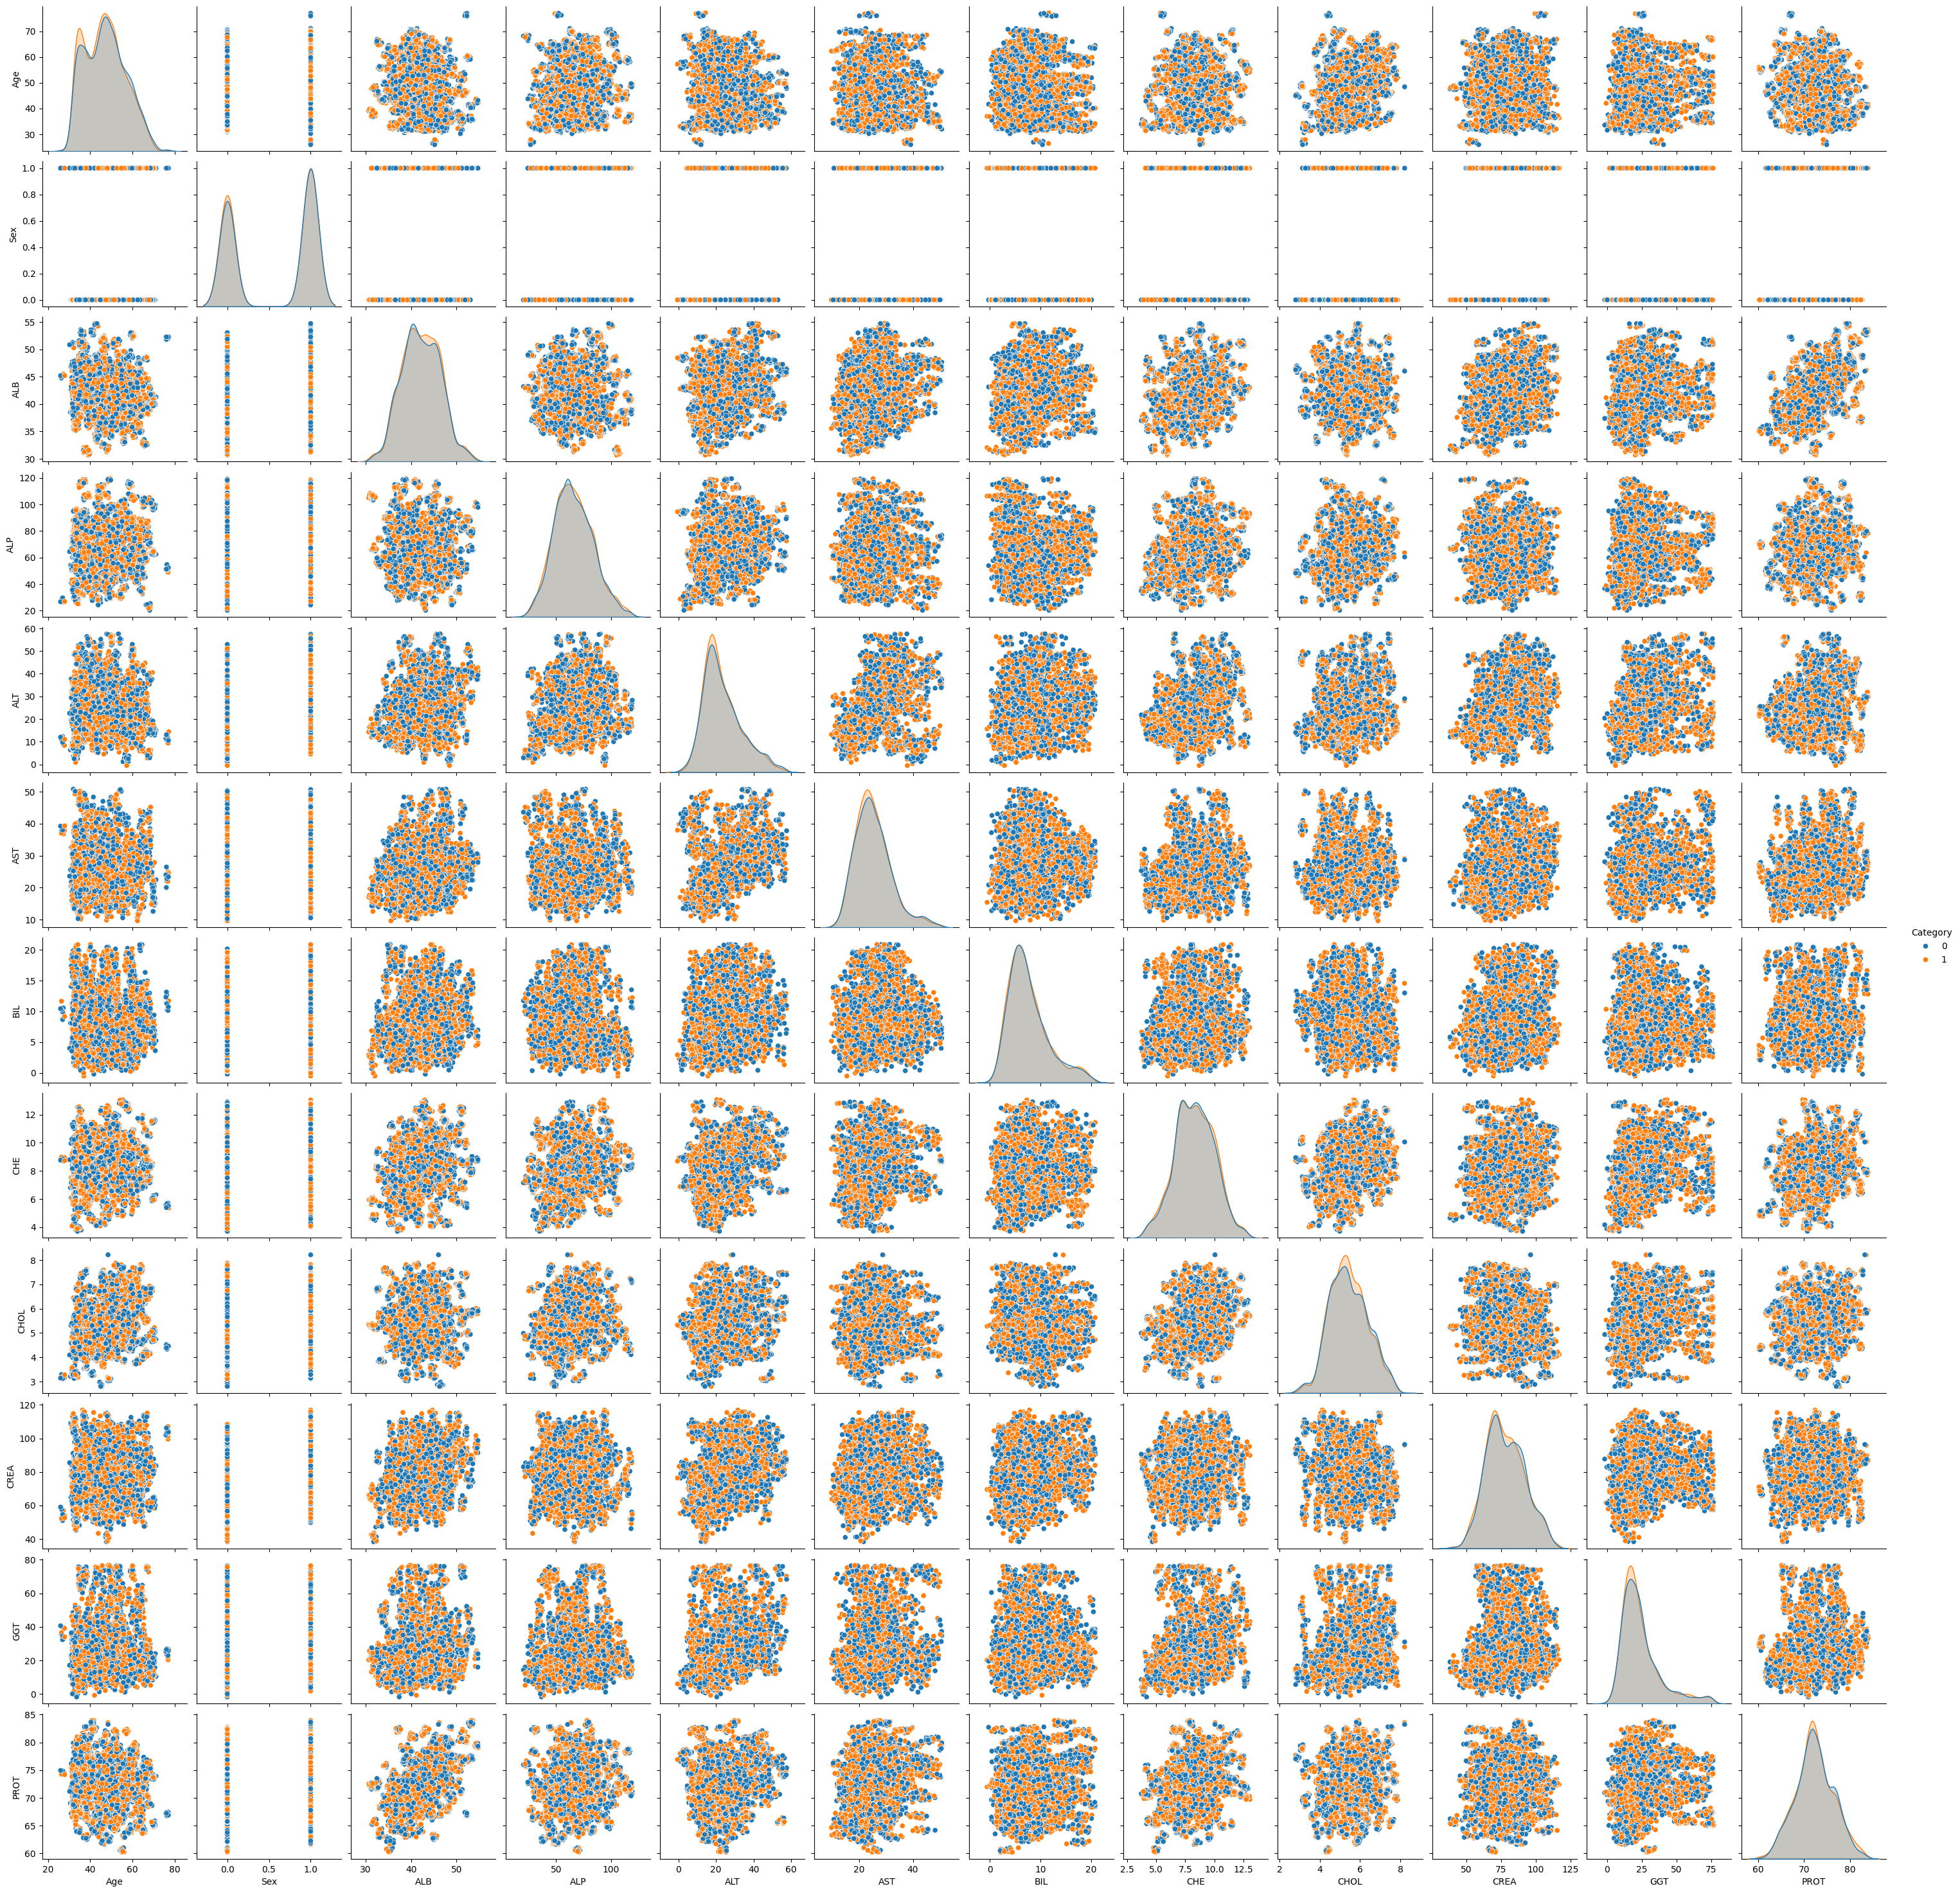

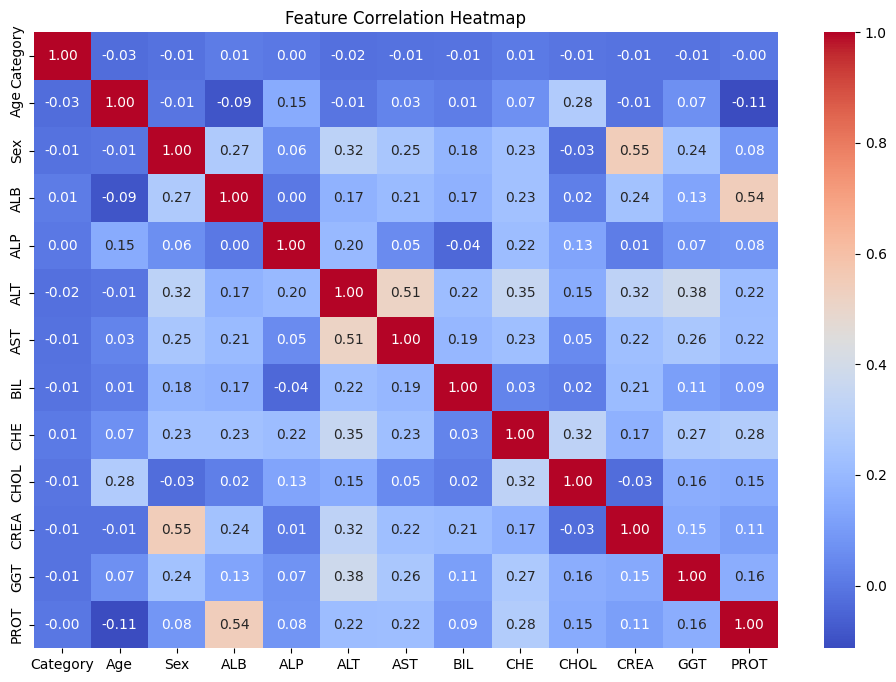

In [17]:
import seaborn as sns
import matplotlib.pyplot as plt

# Pairplot
sns.pairplot(df, hue="Category")
plt.show()

# Correlation Heatmap
plt.figure(figsize=(12, 8))
sns.heatmap(df.corr(), annot=True, cmap='coolwarm', fmt='.2f')
plt.title("Feature Correlation Heatmap")
plt.show()


In [18]:
from imblearn.over_sampling import SMOTE

X = df.drop(columns=['Category'])
y = df['Category']

smote = SMOTE(random_state=42)
X, y = smote.fit_resample(X, y)

In [19]:
df['Category'].value_counts()

Category
1    3686
0    3611
Name: count, dtype: int64

In [20]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.feature_selection import RFE

rf = RandomForestClassifier(n_estimators=100, random_state=42)
rfe = RFE(rf, n_features_to_select=5)
rfe.fit(X, y)

selected_features = X.columns[rfe.support_].tolist()
print("Top 5 selected features:", selected_features)

# Use only selected features
X = X[selected_features]

Top 5 selected features: ['ALT', 'AST', 'BIL', 'CHE', 'GGT']


In [34]:
selected_features

['ALT', 'AST', 'BIL', 'CHE', 'GGT']

In [22]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [23]:
from sklearn.preprocessing import StandardScaler

scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

In [24]:
from sklearn.naive_bayes import GaussianNB
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC
from sklearn.neighbors import KNeighborsClassifier

# Define models
models = {
    "Naive Bayes": GaussianNB(),
    "Logistic Regression": LogisticRegression(),
    "Random Forest": RandomForestClassifier(n_estimators=100, random_state=42),
    "SVM": SVC(probability=True),
    "KNN": KNeighborsClassifier(n_neighbors=5)
}

# Train models
for name, model in models.items():
    model.fit(X_train, y_train)

In [25]:
from sklearn.model_selection import GridSearchCV

param_grid = {
    'n_estimators': [50, 100, 200],
    'max_depth': [None, 10, 20]
}

gs_rf = GridSearchCV(RandomForestClassifier(random_state=42), param_grid, cv=5, scoring='accuracy')
gs_rf.fit(X_train, y_train)

print("Best parameters for Random Forest:", gs_rf.best_params_)

Best parameters for Random Forest: {'max_depth': 10, 'n_estimators': 200}



Naive Bayes Results:
              precision    recall  f1-score   support

           0       0.48      0.31      0.37       716
           1       0.51      0.68      0.58       759

    accuracy                           0.50      1475
   macro avg       0.49      0.49      0.48      1475
weighted avg       0.49      0.50      0.48      1475



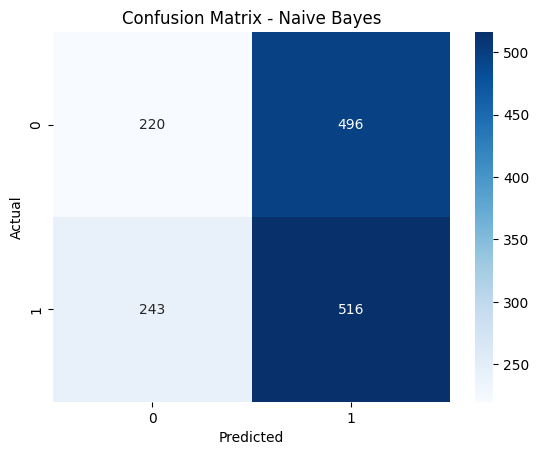


Logistic Regression Results:
              precision    recall  f1-score   support

           0       0.49      0.55      0.52       716
           1       0.53      0.47      0.49       759

    accuracy                           0.51      1475
   macro avg       0.51      0.51      0.51      1475
weighted avg       0.51      0.51      0.51      1475



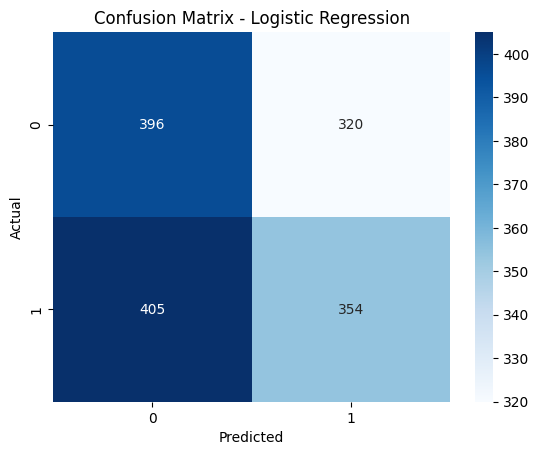


Random Forest Results:
              precision    recall  f1-score   support

           0       0.52      0.57      0.54       716
           1       0.55      0.50      0.53       759

    accuracy                           0.53      1475
   macro avg       0.54      0.54      0.53      1475
weighted avg       0.54      0.53      0.53      1475



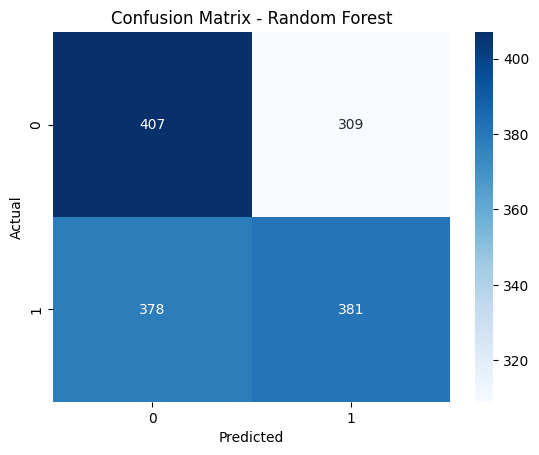


SVM Results:
              precision    recall  f1-score   support

           0       0.49      0.42      0.45       716
           1       0.52      0.59      0.55       759

    accuracy                           0.51      1475
   macro avg       0.51      0.51      0.50      1475
weighted avg       0.51      0.51      0.50      1475



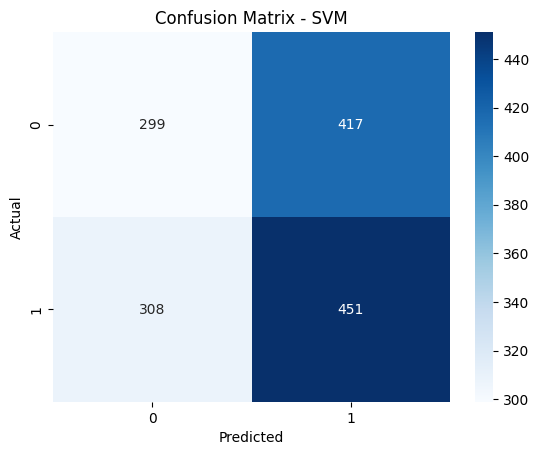


KNN Results:
              precision    recall  f1-score   support

           0       0.51      0.54      0.53       716
           1       0.54      0.51      0.52       759

    accuracy                           0.52      1475
   macro avg       0.53      0.53      0.52      1475
weighted avg       0.53      0.52      0.52      1475



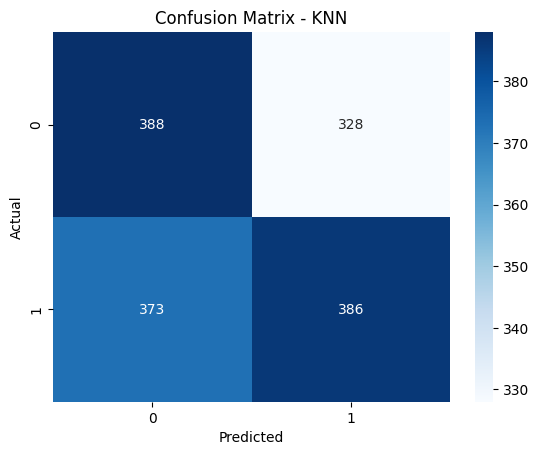


Model Performance Comparison:


Accuracy   ROC AUC
Naive Bayes          0.498983  0.483866
Logistic Regression  0.508475  0.501765
Random Forest        0.534237  0.536616
SVM                  0.508475  0.478857
KNN                  0.524746  0.535517

In [26]:
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix, roc_auc_score

results = {}

for name, model in models.items():
    y_pred = model.predict(X_test)
    y_prob = model.predict_proba(X_test)[:, 1] if hasattr(model, "predict_proba") else None

    acc = accuracy_score(y_test, y_pred)
    roc_auc = roc_auc_score(y_test, y_prob) if y_prob is not None else "N/A"
    results[name] = {"Accuracy": acc, "ROC AUC": roc_auc}

    print(f"\n{name} Results:")
    print(classification_report(y_test, y_pred))

    # Confusion Matrix
    cm = confusion_matrix(y_test, y_pred)
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
    plt.title(f'Confusion Matrix - {name}')
    plt.xlabel('Predicted')
    plt.ylabel('Actual')
    plt.show()

# Display results
results_df = pd.DataFrame(results).T
print("\nModel Performance Comparison:")
display(results_df)

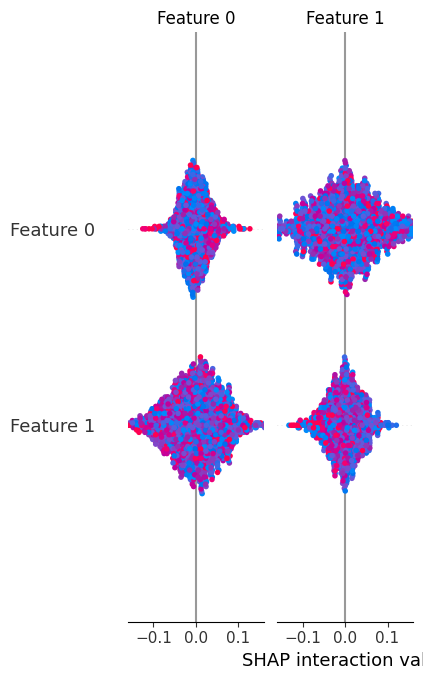

In [27]:
import shap

explainer = shap.Explainer(RandomForestClassifier(n_estimators=100, random_state=42).fit(X_train, y_train))
shap_values = explainer(X_test)

shap.summary_plot(shap_values, X_test)

In [28]:
import joblib

# Save best model and scaler
joblib.dump(models["Random Forest"], "best_model.pkl")
joblib.dump(scaler, "scaler.pkl")


['scaler.pkl']

In [29]:
import streamlit as st
import joblib

model = joblib.load("best_model.pkl")
scaler = joblib.load("scaler.pkl")

st.title("Hepatitis C Prediction")

data = [st.number_input(col) for col in selected_features]
if st.button("Predict"):
    result = model.predict(scaler.transform([data]))
    st.write("Prediction:", "Hepatitis C" if result[0] == 1 else "Healthy")

2025-03-16 10:47:14.191 WARNING streamlit.runtime.scriptrunner_utils.script_run_context: Thread 'MainThread': missing ScriptRunContext! This warning can be ignored when running in bare mode.
2025-03-16 10:47:14.572 
  command:

    streamlit run /usr/local/lib/python3.11/dist-packages/colab_kernel_launcher.py [ARGUMENTS]
2025-03-16 10:47:14.574 Thread 'MainThread': missing ScriptRunContext! This warning can be ignored when running in bare mode.
2025-03-16 10:47:14.577 Thread 'MainThread': missing ScriptRunContext! This warning can be ignored when running in bare mode.
2025-03-16 10:47:14.578 Thread 'MainThread': missing ScriptRunContext! This warning can be ignored when running in bare mode.
2025-03-16 10:47:14.581 Thread 'MainThread': missing ScriptRunContext! This warning can be ignored when running in bare mode.
2025-03-16 10:47:14.586 Thread 'MainThread': missing ScriptRunContext! This warning can be ignored when running in bare mode.
2025-03-16 10:47:14.590 Session state does not 

In [ ]:
!streamlit run app.py




  You can now view your Streamlit app in your browser.

  Local URL: http://localhost:8501
  Network URL: http://172.28.0.12:8501
  External URL: http://34.81.124.128:8501

